# ML4Earth hackathon 2022

Author: Aleksei Zhuravlev

We will start by setting up the environment and importing several packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
# # Don't run this cell if you already cloned the repo
# !git clone https://github.com/AgentSamBond/ML4Earth-Hackathon-2022.git

In [ ]:
%cd ML4Earth-Hackathon-2022

/content/drive/MyDrive/ML4Earth-Hackathon-2022


In [ ]:
# # unzipping data
# # Don't run this cell if you already unzipped the dataset
# import zipfile
# with zipfile.ZipFile('data/npy_corn_2003_2021.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/npy_corn_2003_2021')
# with zipfile.ZipFile('data/npy_soybean_2003_2021.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/npy_soybean_2003_2021')

In [ ]:
from source.datasets.dataset_npy import YieldDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing
from scipy.stats import mstats

# Loading the data
Putting various features together doesn't seem very interesting and is done under the hood in a separate class

In [ ]:
df_yield = pd.read_csv('data/soybean.csv')

data_importer = YieldDataset(
    image_folder='data/npy_soybean_2003_2021/soybean',
    label_path='data/npy_soybean_2003_2021/soybean/labels.json',
    crop_type='soybean',
)

# Visualization

Let us visualize the input data for the county 18007


In [ ]:
# selecting the entries relevant to the county
df_county_yield = df_yield[(df_yield['State ANSI'] == 18) & (df_yield['County ANSI'] == 7)].copy()
df_county_yield.sort_values(by='Year')

# getting the county name and state
state, name = df_county_yield.iloc[0][['State', 'County']]
print(state, name)

INDIANA BENTON


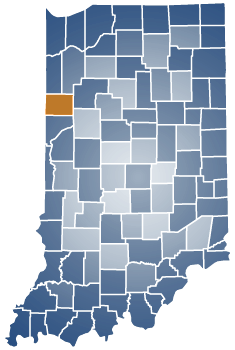

Plotting the soybean yield

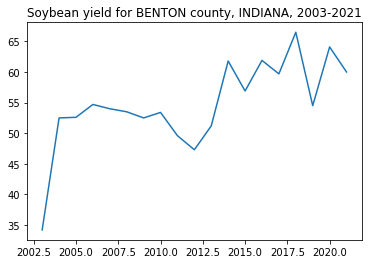

In [ ]:
plt.plot(df_county_yield['Year'].astype(int), df_county_yield['Value'])
plt.title(f'Soybean yield for {name} county, {state}, 2003-2021')
plt.show()

There was a huge drop in the years 2011-2012! Now let us visualize the features to see if this could be predicted. 

For our dataset, 15 features are available:

* 7 types of satellite data: red, near-infra red (NIR), blue, green, near-infra red 2 (NIR2), shortwave infra-red 1 (SWIR1), short-wave infra-red 1
* Minimum temperature
* Maximum temperature
* Precipitation.
* Heat/cold wave index
* Drought index
* Normalized Difference Vegetation Index (NDVI)
* Enhanced Vegetation Index (EVI)
* Normalized Difference Water Index (NDWI)


In [ ]:
# getting the features
df_features = data_importer.get_county_data(18007)
df_features.head(5)

,county,year,yield,RED,NIR,BLUE,GREEN,NIR2,SWIR1,SWIR2,TEMP_MIN,TEMP_MAX,PRCP,HEATWAVE INDEX,DROUGHT INDEX,NDVI,EVI,NDWI
0,18007.0,2003.0,34.2,0.408591,0.446319,0.366645,0.391993,0.383098,0.280108,0.182532,-3.236996,1.114161,2.721880,0.0,1.0,0.119307,0.193004,-0.006507
1,18007.0,2003.0,34.2,0.198596,0.256936,0.133335,0.172113,0.262763,0.265236,0.190205,-8.411975,0.763128,0.282156,0.0,1.0,0.153733,0.244861,-0.030071
2,18007.0,2003.0,34.2,0.588355,0.617890,0.547192,0.572215,0.440999,0.183082,0.102548,-15.442428,-5.129066,0.522417,0.0,1.0,0.025398,0.037866,0.165008
3,18007.0,2003.0,34.2,0.702530,0.716885,0.665180,0.695618,0.483664,0.188101,0.096050,-18.508423,-6.555576,0.919985,0.1,2.0,0.013922,0.020937,0.188397
4,18007.0,2003.0,34.2,0.132705,0.200292,0.067933,0.104678,0.272887,0.294865,0.214468,-7.297771,2.063461,1.672600,0.0,2.0,0.204309,0.328256,-0.155302


Time to plot the features!

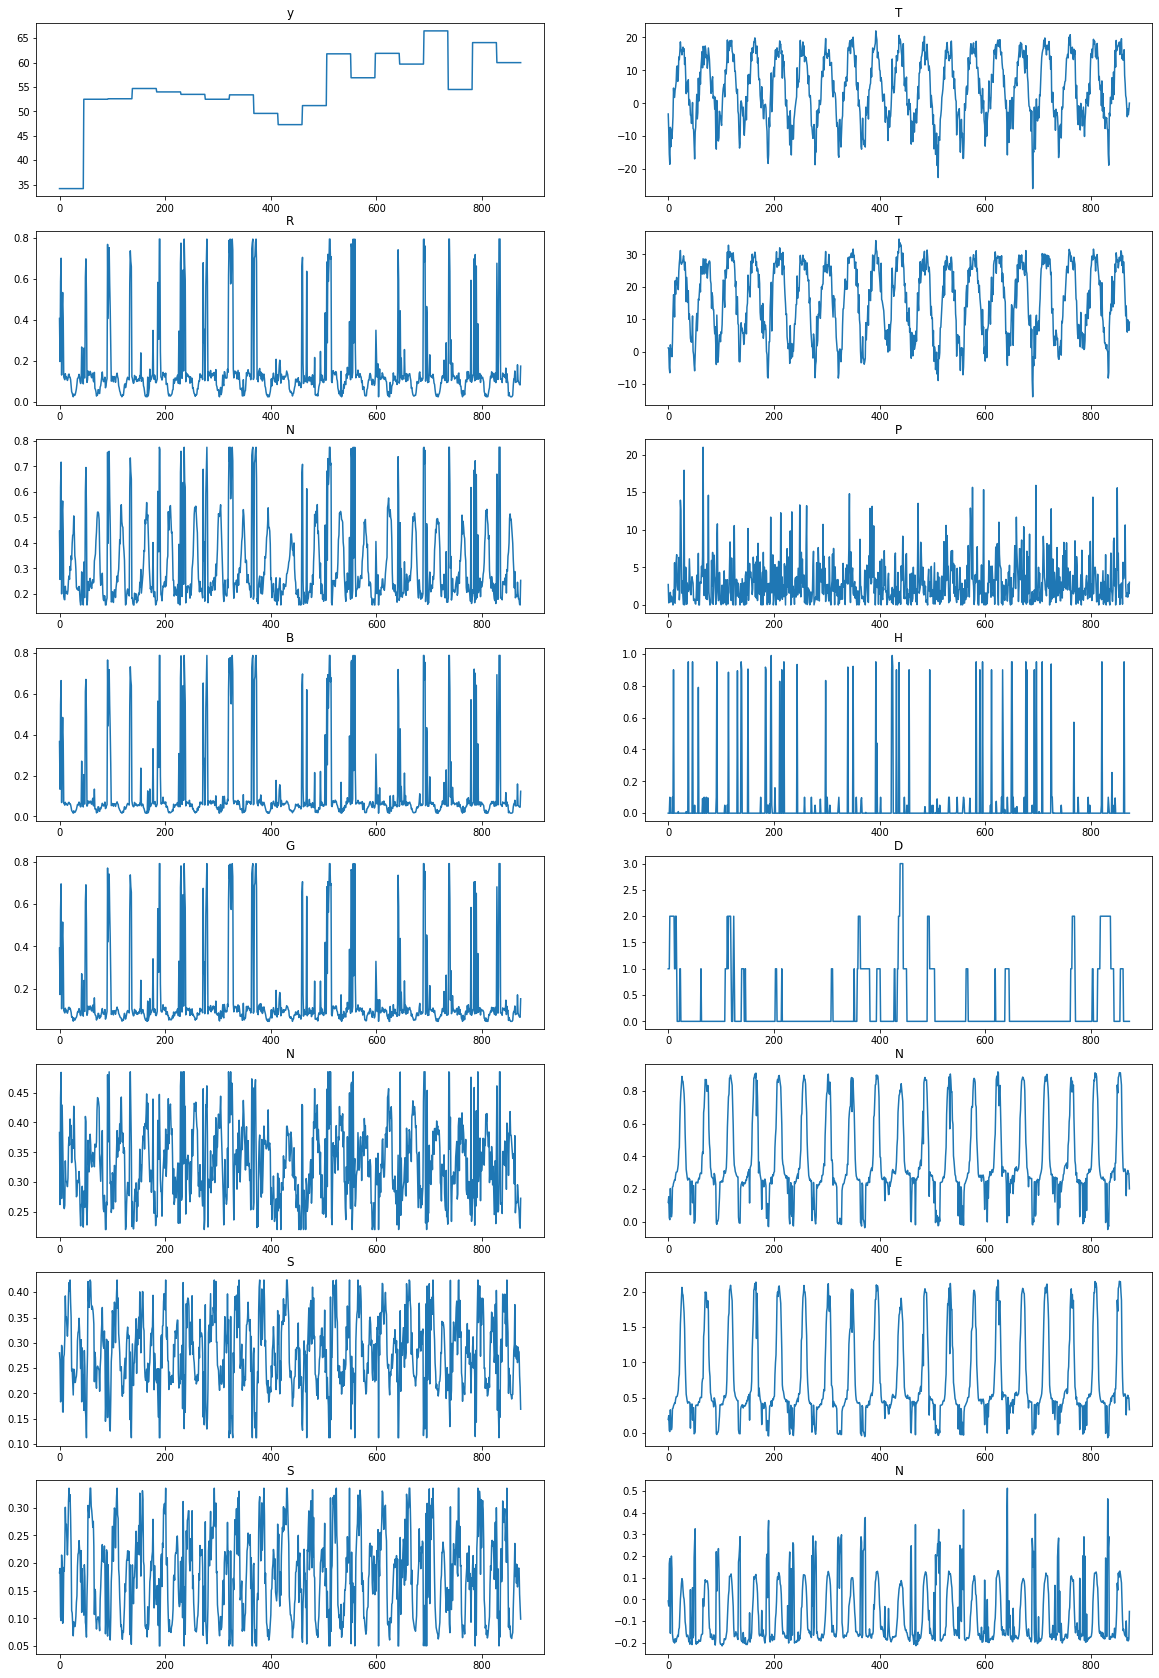

In [ ]:
# satellite data contains outliers,
# here we clip 2% of the entries for plotting
def windsorize_d(df):
  satellite_data_cols = ["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2"]
  for col in satellite_data_cols:
    df[col] = mstats.winsorize(
        df[col],
        limits=[0.02, 0.02]
        )
  return df

df_features = windsorize_d(df_features)
df_features.drop(['year', 'county'], axis=1, inplace=True)

fig, axs = plt.subplots(8, 2, figsize = (20, 30))
n_rows = 8
for i, feature in enumerate(df_features.columns):
  axs[i%n_rows, i// n_rows].plot(df_features.index, df_features[feature])
  axs[i%n_rows, i// n_rows].set_title(feature[0])

Note: during import, we silently remove outliers from the satellite data

Some features look correlated, especially the remote sensing ones:

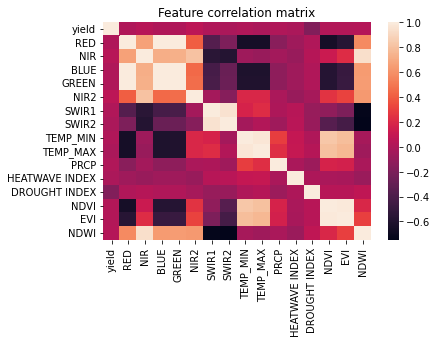

In [ ]:
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns)
plt.title('Feature correlation matrix')
plt.show()

These features are highly correlated:
* RED, BLUE and GREEN
* NIR and NDWI
* SWIR1 and SWIR2
* TEMP_MIN and TEMP_MAX
* NDVI and EWI

Therefore, later we can safely drop BLUE, GREEN, NDWI, SWIR2, TEMP_MAX, EWI

# Preprocessing

### Remove missing data

Altogether we have the data for 473 counties for 2003-2021. Unfortunately, results for some years are missing; let us visualize it

In [ ]:
df_yield = data_importer.data

# here is how the yield data looks like
df_yield.head(5)

,id,year,yield
0,17001,2003,44.0
1,17001,2004,49.0
2,17001,2005,43.0
3,17001,2006,43.0
4,17001,2007,37.0


number of counties: 428


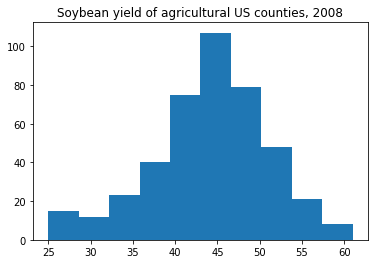

In [ ]:
# histogram of yields for 2008
yields = df_yield[df_yield['year']==2008]['yield']
print('number of counties:', len(yields))
plt.hist(yields)
plt.title('Soybean yield of agricultural US counties, 2008')
plt.show()

Let us see how much data we have available

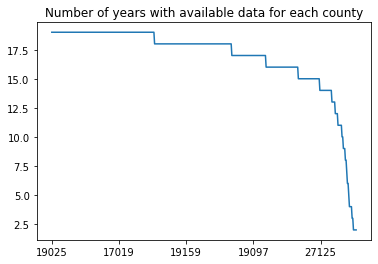

In [ ]:
# available years per county
entries_per_county = df_yield['id'].value_counts()
entries_per_county.plot()
plt.title('Number of years with available data for each county')
plt.show()

It turns out that only 30% of counties have the data for all 18 years since 2003. What can we do about it? 

Let's select the counties with no more than one missing year

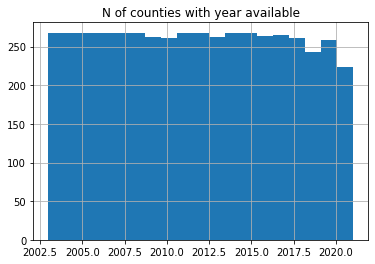

In [ ]:
good_counties = entries_per_county[entries_per_county >= 18]
names = list(good_counties.index)

years = df_yield[df_yield['id'].isin(names)]['year']
years.hist(bins=19)

plt.title('N of counties with year available')
plt.show()

So if we completely drop year 2021, we can keep more than 40% of our dataset!

In [ ]:
df_yield = df_yield[df_yield['year'] != 2021].copy()
entries_per_county = df_yield['id'].value_counts()

good_counties = entries_per_county[entries_per_county == 18]
county_names = list(good_counties.index)

df_full = df_yield[df_yield['id'].isin(county_names)]
print(f'keeping {len(county_names)} counties, {len(county_names) / 473*100:.2f}% of the dataset')

keeping 198 counties, 41.86% of the dataset


### Import the data

We also shuffle the data during import because it will be more tricky later on

In [ ]:
# shuffling
np.random.shuffle(county_names)

# import
raw_data = []
for county in tqdm(county_names):
  df_county = data_importer.get_county_data(county)
  raw_data.append(df_county.copy().astype(float))

100%|██████████| 198/198 [00:28<00:00,  6.89it/s]


### Transformation pipeline

Now we will preprocess the data:
* remove entries for year 2021
* drop correlated features
* remove outliers
* use one-hot encoding on drought index
* normalize the features

In [ ]:
def preprocess_soybean(df_c):

  # removing entries for year 2021
  df_c = df_c[~(df_c['year'] == 2021)].copy()

  df_c.reset_index(drop=True, inplace=True)
  
  # manual one-hot encoding
  drought = df_c['DROUGHT INDEX'].astype("string")
  for i in ['0.0', '1.0', '2.0', '3.0', '4.0']:
    df_c[f'DROUGHT INDEX_{i}'] = (drought == i).astype(int)

  # remove outliers
  satellite_data_cols = ["RED", "NIR", "NIR2", "SWIR1"]
  for col in satellite_data_cols:
    df_c[col] = mstats.winsorize(
        df_c[col],
        limits=[0.02, 0.02]
    )

  # normalize columns
  to_normalize = ['RED', 'NIR','NIR2','SWIR1','TEMP_MIN','PRCP',
                  'HEATWAVE INDEX' ,'NDVI']
  df_c[to_normalize] = df_c[to_normalize].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
 
  # drop the correlated features
  to_drop = ['BLUE', 'GREEN', 'NDWI', 'SWIR2', 'TEMP_MAX',
             'EVI', 'DROUGHT INDEX']
  df_c.drop(to_drop, axis=1, inplace=True)

  return df_c

# example
# df_county = data_importer.get_county_data(17001)
df_county = raw_data[0]
df_county = preprocess_soybean(df_county)
print(df_county)




      county    year  yield       RED       NIR      NIR2     SWIR1  TEMP_MIN  \
0    31159.0  2003.0   42.7 -0.299066 -0.975668 -1.286685  0.289153 -0.997401   
1    31159.0  2003.0   42.7 -0.302564 -1.007376 -1.384074  0.225569 -1.042768   
2    31159.0  2003.0   42.7  2.592092  2.165143  1.605072 -1.276786 -1.666154   
3    31159.0  2003.0   42.7 -0.171374 -0.859565 -1.589624 -0.326321 -1.766821   
4    31159.0  2003.0   42.7  1.913928  1.651637  1.769856 -0.530944 -0.768108   
..       ...     ...    ...       ...       ...       ...       ...       ...   
823  31159.0  2020.0   60.4 -0.165392 -0.690262 -0.637508  0.236404 -0.544920   
824  31159.0  2020.0   60.4 -0.111923 -0.597520 -0.232588  0.632033 -0.929392   
825  31159.0  2020.0   60.4  3.494192  3.172954  2.173925 -1.862434 -0.791396   
826  31159.0  2020.0   60.4  1.062231  0.699167 -0.081074 -0.646425 -1.156060   
827  31159.0  2020.0   60.4  0.932122  0.420813 -1.152646 -1.281611 -1.124403   

         PRCP  HEATWAVE IND

### Reshape

Finally, before we feed the data to ML algorithms, we need to reshape the input features. For each county, we should have a 18 x 598 array of training data and 18 labels of crop yields for the corresponding year.

In [ ]:
def reshape_soybean(df):

  # creating new column names
  cols_old = np.array(df.columns[3:])
  cols_new = np.array([cols_old + f'_{i}' for i in range(46)])
  cols_new = np.concatenate([['county', 'year', 'yield'], cols_new.flatten()])

  new_dataset = []
  for year, df_group in df.groupby('year'):
    yield_yearly = df_group.iloc[0]['yield']
    county_id = df_group.iloc[0]['county']
    
    df_tmp = df_group.copy()
    df_tmp.drop(['county', 'year', 'yield'], axis=1, inplace=True)
    
    # flattening yearly dataframe
    arr = df_tmp.to_numpy()
    arr = arr.flatten()
    arr = np.concatenate([[county_id, year, yield_yearly], arr])
    new_dataset.append(arr)

  df_new = pd.DataFrame(data=new_dataset, columns=cols_new)

  return df_new

df_county = reshape_soybean(df_county)
print(df_county)

     county    year  yield     RED_0     NIR_0    NIR2_0   SWIR1_0  \
0   31159.0  2003.0   42.7 -0.299066 -0.975668 -1.286685  0.289153   
1   31159.0  2004.0   51.4 -0.298596 -0.968402 -1.326883  0.128516   
2   31159.0  2005.0   49.6  3.786012  3.283152  2.571846 -0.362637   
3   31159.0  2006.0   51.4 -0.336963 -1.080469 -1.759947 -0.161194   
4   31159.0  2007.0   55.2 -0.355168 -1.083256 -2.105100 -0.634696   
5   31159.0  2008.0   52.0  3.353719  2.728507 -0.579144 -2.556324   
6   31159.0  2009.0   56.5 -0.176006 -0.839356 -1.221983  0.117188   
7   31159.0  2010.0   53.0  3.786012  3.283152  1.819110 -1.694251   
8   31159.0  2011.0   56.1 -0.020246 -0.517127 -0.321708  0.219226   
9   31159.0  2012.0   42.1 -0.091850 -0.620394 -0.340655  0.691390   
10  31159.0  2013.0   55.1  3.786012  3.283152  1.563747 -2.556324   
11  31159.0  2014.0   58.0  0.699713  0.364558  0.619220 -0.048821   
12  31159.0  2015.0   60.6  2.346306  2.029864  1.497185 -1.618766   
13  31159.0  2016.0 

Time to put everything together and create the master dataset

In [ ]:
sub_list = []
# print(df_raw.values())
for df_county in tqdm(raw_data):
  df_ppr = preprocess_soybean(df_county.copy())
  df_ppr = reshape_soybean(df_ppr)
  sub_list.append(df_ppr)

df_master = pd.concat(sub_list)
df_master.reset_index(inplace=True, drop=True)
df_master

100%|██████████| 198/198 [00:11<00:00, 17.16it/s]


,county,year,yield,RED_0,NIR_0,NIR2_0,SWIR1_0,TEMP_MIN_0,PRCP_0,HEATWAVE INDEX_0,...,SWIR1_45,TEMP_MIN_45,PRCP_45,HEATWAVE INDEX_45,NDVI_45,DROUGHT INDEX_0.0_45,DROUGHT INDEX_1.0_45,DROUGHT INDEX_2.0_45,DROUGHT INDEX_3.0_45,DROUGHT INDEX_4.0_45
0,31159.0,2003.0,42.7,-0.299066,-0.975668,-1.286685,0.289153,-0.997401,-0.785782,-0.244882,...,0.119746,-0.837744,-0.785782,-0.244882,-0.516773,0.0,0.0,1.0,0.0,0.0
1,31159.0,2004.0,51.4,-0.298596,-0.968402,-1.326883,0.128516,-0.999988,-0.346219,-0.244882,...,0.011556,-1.421498,-0.785782,-0.244882,-0.624948,0.0,1.0,0.0,0.0,0.0
2,31159.0,2005.0,49.6,3.786012,3.283152,2.571846,-0.362637,-0.939993,-0.499223,-0.244882,...,-0.545832,-0.593130,-0.761644,-0.244882,-0.612697,0.0,1.0,0.0,0.0,0.0
3,31159.0,2006.0,51.4,-0.336963,-1.080469,-1.759947,-0.161194,-0.749009,-0.721088,4.591325,...,-2.080094,-0.737889,1.190083,-0.244882,-1.076101,0.0,1.0,0.0,0.0,0.0
4,31159.0,2007.0,55.2,-0.355168,-1.083256,-2.105100,-0.634696,-0.910938,-0.649025,-0.244882,...,-2.556324,-1.428815,-0.785738,-0.244882,-1.661222,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,18129.0,2016.0,53.9,-0.284413,-1.228857,-1.856493,-1.496684,-1.023830,-0.958626,-0.295809,...,-0.909171,-0.819324,0.277517,-0.295809,-0.310100,1.0,0.0,0.0,0.0,0.0
3560,18129.0,2017.0,56.6,-0.290584,-1.032349,-1.258882,-0.624602,-0.634546,-0.565320,2.829410,...,0.766843,-1.877866,-0.669945,0.088621,-0.638091,1.0,0.0,0.0,0.0,0.0
3561,18129.0,2018.0,54.4,0.160496,-0.738435,-0.214321,1.119207,-2.751697,-0.958626,-0.251927,...,0.237187,-0.966507,-0.072176,-0.295809,-1.334023,1.0,0.0,0.0,0.0,0.0
3562,18129.0,2019.0,56.3,-0.320332,-1.310398,-1.880438,-1.800113,-0.800370,0.316066,-0.295809,...,-0.177752,-0.461057,0.255003,3.653582,-0.597744,1.0,0.0,0.0,0.0,0.0


# Model selection

### Objective

**Given historical data for 198 US counties for previous years, as well as the remote sensing and weather data for the current year, predict soybean yield for the target county**

### Train / test split

For our objective, we need to specify the way we split the data. 

* The model will be trained on historical data from 2003 to 2018 for all available counties. 

* The data for 2019-2020 will be the test set.  

* Shuffling was made during import

In [ ]:
X_train = df_master[df_master['year'] <= 2018].drop(['county', 'year', 'yield'], axis=1).copy()
y_train = df_master[df_master['year'] <= 2018]['yield'].copy()

X_test = df_master[(df_master['year'] > 2018)].drop(['county', 'year', 'yield'], axis=1).copy()
y_test = df_master[(df_master['year'] > 2018)]['yield'].copy()

print(X_train.shape, X_test.shape)

(3168, 598) (396, 598)


### Dimensionality reduction

Let us apply Principal Component Analysis for dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_r = pca.fit_transform(X_train)
X_test_r = pca.transform(X_test)

print(X_train_r.shape, X_test_r.shape)

(3168, 126) (396, 126)


It turns out that out of ~600 features, only ~120 had useful information. This will help speed up the training.

# Linear regression and Random Forest

Let's try a linear regression model and a random forest to see what accuracy we can achieve with simple algorithms

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, get_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

def train_validate_model(model, name, validation=True):

  # making pipeline with PCA and the model
  pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95),
       model
       )


  print(name)

  if validation:
    rmses = -cross_val_score(pipe, X_train, y_train,
                          scoring="neg_root_mean_squared_error", cv=5)
    print('cross validation')
    print(f'mean_RMSE: {rmses.mean():.2f}, mean_RMSE / mean(y): {rmses.mean() / y_train.mean()*100:.1f}%')

  pipe.fit(X_train, y_train)
  pred_train = pipe.predict(X_train)
  rmse_train = mean_squared_error(y_train, pred_train, squared=False)

  if not validation:
    print('train')
    print(f'RMSE: {rmse_train:.2f}, RMSE / mean: {rmse_train / y_train.mean()*100:.1f}%')


  # performance on the test set
  pred_test = pipe.predict(X_test)
  rmse_test = mean_squared_error(y_test, pred_test, squared=False)
  print('test')
  print(f'RMSE: {rmse_test:.2f}, RMSE / mean: {rmse_test / y_test.mean()*100:.1f}%\n')

In [ ]:
train_validate_model(LinearRegression(), 'linear regression')

linear regression
cross validation
mean_RMSE: 4.06, mean_RMSE / mean(y): 8.2%
test
RMSE: 7.51, RMSE / mean: 13.6%



The linear regression and random forest models both have a good cross validation score, and perform worse on the test set.

# Deep neural network

Now let us try a more powerful model. For this regression task we will use the following architecture:
- an input layer
- a dense layer with 200 neurons, ReLu activation function
- a dropout layer for regularization
- a batch normalization layer
- a dense layer with 100 neurons, ReLu
- a dropout layer
- a dense layer with 70 neurons, ReLu
- a batch normalization layer
- a dense layer with 30 neurons, ReLu
- a dropout layer
- a dense layer with 15 neurons, ReLu
- an output layer

In [ ]:
import tensorflow as tf
from sklearn.model_selection import KFold

def make_deep_nn(input_shape):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(input_shape),
      tf.keras.layers.Dense(200, activation="relu"),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(100, activation="relu"),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(70, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
  ])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=7)

  model.compile(loss="mse",  metrics=["RootMeanSquaredError"], 
                optimizer=tf.keras.optimizers.Adam(0.0006))
  return model


def cross_validation(model):
  kf = KFold(n_splits=5)
  kf.get_n_splits(X_train_r)
  
  # Loop over the dataset to create seprate folds
  rmses = []
  for train_index, val_index in kf.split(X_train_r):
    X_tr, X_va = X_train_r[train_index], X_train_r[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    history = model.fit(X_tr, y_tr, epochs=50, verbose=0,
      validation_data=(X_va, y_va), #callbacks=[callback]
    )
    pred_val = model.predict(X_va)
    rmse_val = mean_squared_error(y_va, pred_val, squared=False)
    rmses.append(rmse_val)
  
  rmses = np.array(rmses)
  print('cross validation')
  print(f'mean_RMSE: {rmses.mean():.2f}, mean_RMSE / mean(y): {rmses.mean() / y_va.mean()*100:.1f}%')

Epoch 1/50
99/99 [==============================] - 2s 10ms/step - loss: 2366.0066 - root_mean_squared_error: 48.6416 - val_loss: 2613.8652 - val_root_mean_squared_error: 51.1260
Epoch 2/50
99/99 [==============================] - 1s 7ms/step - loss: 1320.4124 - root_mean_squared_error: 36.3375 - val_loss: 703.7841 - val_root_mean_squared_error: 26.5289
Epoch 3/50
99/99 [==============================] - 1s 7ms/step - loss: 331.9648 - root_mean_squared_error: 18.2199 - val_loss: 343.7642 - val_root_mean_squared_error: 18.5409
Epoch 4/50
99/99 [==============================] - 1s 7ms/step - loss: 183.9549 - root_mean_squared_error: 13.5630 - val_loss: 257.1785 - val_root_mean_squared_error: 16.0368
Epoch 5/50
99/99 [==============================] - 1s 8ms/step - loss: 164.6087 - root_mean_squared_error: 12.8300 - val_loss: 182.4922 - val_root_mean_squared_error: 13.5090
Epoch 6/50
99/99 [==============================] - 1s 7ms/step - loss: 139.2114 - root_mean_squared_error: 11.7988 

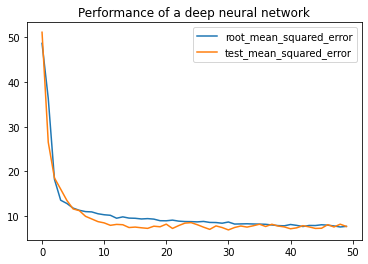

In [ ]:
# training
model = make_deep_nn(X_train.shape[1])

history = model.fit(X_train_r, y_train, epochs=50,
    validation_data=(X_test_r, y_test), #callbacks=[callback]
)

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Performance of a deep neural network')
plt.legend(['root_mean_squared_error', 'test_mean_squared_error'])
plt.show()

Cross validation on 5 splits:

In [ ]:
cross_validation(model)

20/20 [==============================] - 0s 3ms/step
cross validation
mean_RMSE: 2.98, mean_RMSE / mean(y): 6.1%


# Fine-tune

Using a deep neural network, we were able to bring the error down to 9%. But can we do better?

Here is how our approach could be improved:

* we trained our model only on the satellite/climatic data for the current year
* we disregard the climatic conditions during the previous year
* the model does not know how the county's usual soybean yield looks like; this is important since the amount of farmland can vary a lot from county to county

Let us address those points by using the previous year's satellite/climatic data and yield as additional features. Data for year 2003 will only be used as features for year 2004.

In [ ]:
def add_prev_year_features(df):
  # creating new column names
  cols_old = np.array(df.columns)
  cols_new = np.array([col_name + f'_prev' for col_name in cols_old[2:]])
  cols_new = np.concatenate([cols_old, cols_new.flatten()])

  # creating the dataset
  new_data = []
  for county_id, df_group in df.groupby('county'):
      arr = df_group.to_numpy()
      for i in range(1, len(arr)):
          new_data.append(
            np.concatenate([arr[i], arr[i-1][2:]])
            )
  df_new = pd.DataFrame(data=new_data, columns=cols_new)
  return df_new

In [ ]:
df_master_new = add_prev_year_features(df_master)
print(df_master_new.shape)
df_master_new[['county', 'year', 'yield', 'yield_prev']]

(3366, 1200)


,county,year,yield,yield_prev
0,17001.0,2004.0,49.0,44.0
1,17001.0,2005.0,43.0,49.0
2,17001.0,2006.0,43.0,43.0
3,17001.0,2007.0,37.0,43.0
4,17001.0,2008.0,41.0,37.0
...,...,...,...,...
3361,31181.0,2016.0,54.5,46.7
3362,31181.0,2017.0,54.6,54.5
3363,31181.0,2018.0,53.7,54.6
3364,31181.0,2019.0,54.3,53.7


Train / test split, as before

In [ ]:
X_train = df_master_new[df_master_new['year'] <= 2018].drop(['county', 'year', 'yield'], axis=1).copy()
y_train = df_master_new[df_master_new['year'] <= 2018]['yield'].copy()

X_test = df_master_new[(df_master_new['year'] > 2018)].drop(['county', 'year', 'yield'], axis=1).copy()
y_test = df_master_new[(df_master_new['year'] > 2018)]['yield'].copy()

print(X_train.shape, X_test.shape)

(2970, 1197) (396, 1197)


We added almost 600 new features, but how useful was this information? Let us apply PCA and see:

In [ ]:
# scaling and dimensionality reduction
preprocessing_pipeline = make_pipeline(
  StandardScaler(),
  PCA(n_components=0.95)
)
X_train_r = preprocessing_pipeline.fit_transform(X_train)
X_test_r = preprocessing_pipeline.transform(X_test)

print(X_train_r.shape, X_test_r.shape)

(2970, 303) (396, 303)


Now we have almost 300 features, instead of ~120 before. Using the previous year's data gave the model almost 50% more information!

### Linear regression

Implementing cross-validation on the updated set is tricky, and we will not use it here. The reason is that the validation year can be between the training years, and the model will see the information about its yield.

In [ ]:
train_validate_model(LinearRegression(), 'linear regression', validation=True)
# train_validate_model(RandomForestRegressor(), 'random forest', validation=False)

linear regression
cross validation
mean_RMSE: 4.43, mean_RMSE / mean(y): 8.8%
test
RMSE: 5.77, RMSE / mean: 10.5%



In [ ]:
from sklearn.metrics import r2_score
lr = LinearRegression()
lr.fit(X_train_r, y_train)
pred = lr.predict(X_test_r)
r2_score(y_test, pred)

0.25660960757649576

Using the previous year's data reduced the error by almost 30%!

### Deep learning

Epoch 1/40
93/93 [==============================] - 2s 9ms/step - loss: 2402.6743 - root_mean_squared_error: 49.0171 - val_loss: 2608.6863 - val_root_mean_squared_error: 51.0753
Epoch 2/40
93/93 [==============================] - 1s 6ms/step - loss: 1338.4773 - root_mean_squared_error: 36.5852 - val_loss: 605.0567 - val_root_mean_squared_error: 24.5979
Epoch 3/40
93/93 [==============================] - 1s 7ms/step - loss: 276.6456 - root_mean_squared_error: 16.6327 - val_loss: 290.2622 - val_root_mean_squared_error: 17.0371
Epoch 4/40
93/93 [==============================] - 1s 7ms/step - loss: 186.9106 - root_mean_squared_error: 13.6715 - val_loss: 225.6335 - val_root_mean_squared_error: 15.0211
Epoch 5/40
93/93 [==============================] - 1s 10ms/step - loss: 163.9439 - root_mean_squared_error: 12.8041 - val_loss: 181.2899 - val_root_mean_squared_error: 13.4644
Epoch 6/40
93/93 [==============================] - 1s 12ms/step - loss: 148.7596 - root_mean_squared_error: 12.1967

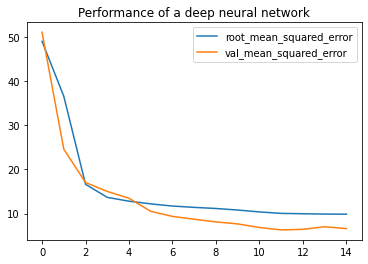

In [ ]:
model = make_deep_nn(X_train_r.shape[1])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)


history = model.fit(X_train_r, y_train, epochs=40,
  validation_data=(X_test_r, y_test), callbacks=[callback]
)

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Performance of a deep neural network')
plt.legend(['root_mean_squared_error', 'val_mean_squared_error'])
plt.show()

In [ ]:
cross_validation(model)

19/19 [==============================] - 0s 3ms/step
cross validation
mean_RMSE: 6.72, mean_RMSE / mean(y): 13.7%


# Explainable AI

We have trained a deep neural network and a linear regression model. But NN is a black-box model, and for regression we applied PCA which merges old features into new ones. As a result, we cannot see what features contribute the most to the soybean yield. 

As we have already seen, using the data for the previous year significantly improves the performance of our models.

### Permutation

Now we will apply permutation to examine the importance of the following features:
* RED
* NIR/NIR2
* SWIR1
* TEMP_MIN
* PRCP
* HEATWAVE INDEX
* NDVI
* DROUGHT INDEX
* previous year's data

In [ ]:
from sklearn.inspection import permutation_importance

# we will use a linear regression model
# because it is faster to train
pipe = make_pipeline(
  StandardScaler(),
        PCA(n_components=0.95),
       LinearRegression()
       )
pipe.fit(X_train, y_train)

result = permutation_importance(pipe, X_train, y_train, n_repeats=1,
                                 random_state=0)

# match feature importances with column names
feature_names = df_master_new.columns[3:]
feature_importances = list(zip(feature_names, result['importances_mean'], result['importances_std']))
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [ ]:
# helper functions to plot the data

def get_feature_importance_curr_year(feature_importances):
  feature_values = dict()
  for entry in feature_importances:
    name = entry[0]
    if 'prev' in name.split('_'):
      continue

    stemmed_name = name.split('_')[0]
    if stemmed_name not in feature_values:
      feature_values[stemmed_name] = entry[1]
    else:
      feature_values[stemmed_name] += entry[1]

  items = sorted(feature_values.items(), key=lambda x: x[1], reverse=True)
  return zip(*items)

def get_feature_importance_prev_year(feature_importances):
  feature_values = dict()
  for entry in feature_importances:
    name = entry[0]
    if 'prev' not in name.split('_') and name != 'yield':
      continue

    stemmed_name = name.split('_')[0]
    if stemmed_name not in feature_values:
      feature_values[stemmed_name] = entry[1]
    else:
      feature_values[stemmed_name] += entry[1]

  items = sorted(feature_values.items(), key=lambda x: x[1], reverse=True)
  return zip(*items)

def get_feature_importance_day_curr(feature_importances):
  feature_values = dict()
  for entry in feature_importances:
    name = entry[0]
    if 'prev' in name.split('_') or name == 'yield':
      continue

    day = str(name.split('_')[-1])
    if day not in feature_values:
      feature_values[day] = entry[1]
    else:
      feature_values[day] += entry[1]

  items = list(feature_values.items())
  for i in range(len(items)):
    items[i] = (int(items[i][0]), items[i][1])
    
  items = sorted(items, key=lambda x: x[0], reverse=False)
  return zip(*items)

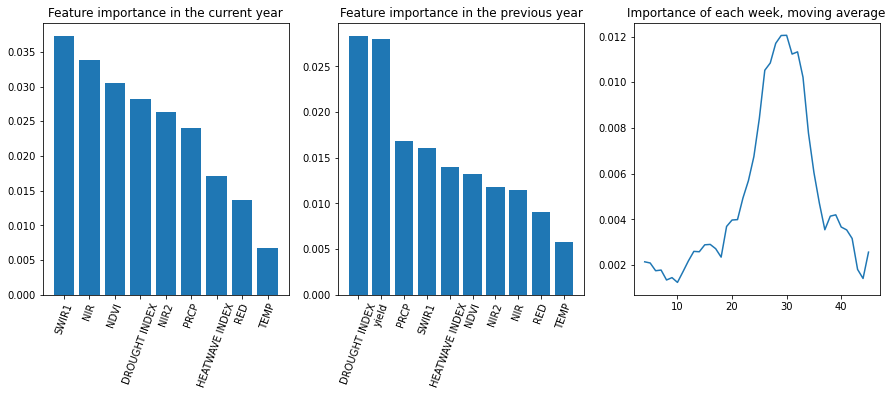

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

x, y = get_feature_importance_curr_year(feature_importances)
axs[0].bar(x, y)
axs[0].set_title("Feature importance in the current year")
axs[0].set_xticklabels(x, rotation=70)

x, y = get_feature_importance_prev_year(feature_importances)
axs[1].bar(x, y)
axs[1].set_title("Feature importance in the previous year")
axs[1].set_xticklabels(x, rotation=70)

x, y = get_feature_importance_day_curr(feature_importances)
data = pd.Series(y, index=x)
mov_avg = data.rolling(window=5).mean()
axs[2].plot(x, mov_avg)
axs[2].set_title("Importance of each week, moving average")
plt.show()